In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
print('Pandas version \t', pd.__version__)
print('Numpy version \t', np.__version__)
print('Matplotlib version \t', matplotlib.__version__)
print('Seaborn version \t', sns.__version__)
print('Sklearn version \t', sklearn.__version__)  
print('Statsmodels version \t', sm.__version__)  


Pandas version 	 1.0.5
Numpy version 	 1.18.5
Matplotlib version 	 3.2.2
Seaborn version 	 0.10.1
Sklearn version 	 0.23.1
Statsmodels version 	 0.11.1


## General Approach

Step 1 : EDA
1. Load the data
2. Inspect the data / High level overview
3. Check if any data is blank and perform data quality checks as below
4. transform as per meta data all columns [categorical] where ever requried like season / Weekday / weathersit / yr / mnth
5. drop columns which are not requried for analysis
6. pair plot for all numeric columns

Step 2 : Preparing data for regression
7. Create Dummy variables
8. Original columns are dropped
Step 3: Train / Test Data Split / Scalling the training numeric vars / Heat Map
9. Train & Test split 70 / 30
10. Scale the train data only the numeric columns
11. Heatmap plot to understand co-relation
Step 4: Building Model / Choose optimal number of var count for RFE
12. Perform Linear Regression using RFE
13. Choose top 15 variables
Step 5: Optimising model / Dropping vars based on -p-value and VIF, validate again,drop and repeat untill VIF < 5 and p-value is low
14. Check summary result and drop variable having p-value >0
15. Finally check VIF values if any column > 5 then drop that column as well
Step 6: Residual analysis
16. Perform Residual analysis on training output and training pred
17. validate of group Zero is in middle and shape is correct
Step 7 : Scalling the numeric test vars / Fit model
18. Now scale the test data
19. fit the model with const
Step 8 : model Evaluation  / R2 Score
20. Evaluate model using scatter plot
21. Calculate R2 score and compare with RSquare it it within 5 %5 range


# Assumptions
1. Linear Relationship with Indepdenent & Dependent variable
2. Residual are normally distributed
3. No Multicollinearity - VIF < 5
4. Homoscedasticity - Residual have constant variance n linear model

In [3]:
# read the data
bikes = pd.read_csv('day.csv')
bikes.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
# Check shape
bikes.shape

(730, 16)

In [5]:
# Check basic info of data
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [6]:
# Data quality
# Columns data type
# Null values
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
# DQ 1: transform season from numeric to categorical vars
bikes[['season']] = bikes[['season']].apply(lambda x: x.map({1 :'spring',2 :'summer',3 :'fall',4:'winter'}))

In [8]:
bikes.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [9]:
# DQ 2: transform weekday from numeric to categorical vars
bikes[['weekday']] = bikes[['weekday']].apply(lambda x: x.map({1 :'Monday',2 :'Tuesday',3 :'Wednesday'
                                                               ,4:'Thursday',5:'Friday',6:'Saturday',0:'Sunday'}))

In [10]:
bikes.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,Saturday,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,Sunday,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,Monday,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,Tuesday,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,Wednesday,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [11]:
bikes.weathersit.unique()

array([2, 1, 3], dtype=int64)

In [12]:
# DQ 3: transform weathersit from numeric to categorical vars
bikes[['weathersit']] = bikes[['weathersit']].apply(lambda x: x.map({1 :'Clear Weather',2 :'Mist',3 :'LightBadWeather'
                                                               ,4:'BadWeather'}))

In [13]:
bikes.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [14]:
# DQ 4: transform yr from numeric to categorical vars
bikes[['yr']] = bikes[['yr']].apply(lambda x: x.map({0 :'2018',1 :'2019'}))

In [15]:
bikes.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,2018,1,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,2018,1,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,2018,1,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,2018,1,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,2018,1,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [16]:
# DQ 5: transform mnth from numeric to categorical vars
bikes[['mnth']] = bikes[['mnth']].apply(lambda x: x.map({1 :'Jan',2 :'Feb',3 :'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}))

In [17]:
bikes.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Dropping Columns

- instant - Just a counter
- dteday - 
- casual & registered as target variable is cnt

In [18]:
# DQ 6: transform mnth from numeric to categorical vars
bikes.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

In [19]:
bikes.head(20)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,12.522300,1600
5,spring,2018,Jan,0,Thursday,1,Clear Weather,8.378268,11.66045,51.8261,6.000868,1606
6,spring,2018,Jan,0,Friday,1,Mist,8.057402,10.44195,49.8696,11.304642,1510
7,spring,2018,Jan,0,Saturday,0,Mist,6.765000,8.11270,53.5833,17.875868,959
8,spring,2018,Jan,0,Sunday,0,Clear Weather,5.671653,5.80875,43.4167,24.250650,822
9,spring,2018,Jan,0,Monday,1,Clear Weather,6.184153,7.54440,48.2917,14.958889,1321


In [20]:
## get numeric vars
numeric_vars = ['temp','atemp','hum','windspeed',
           'cnt']

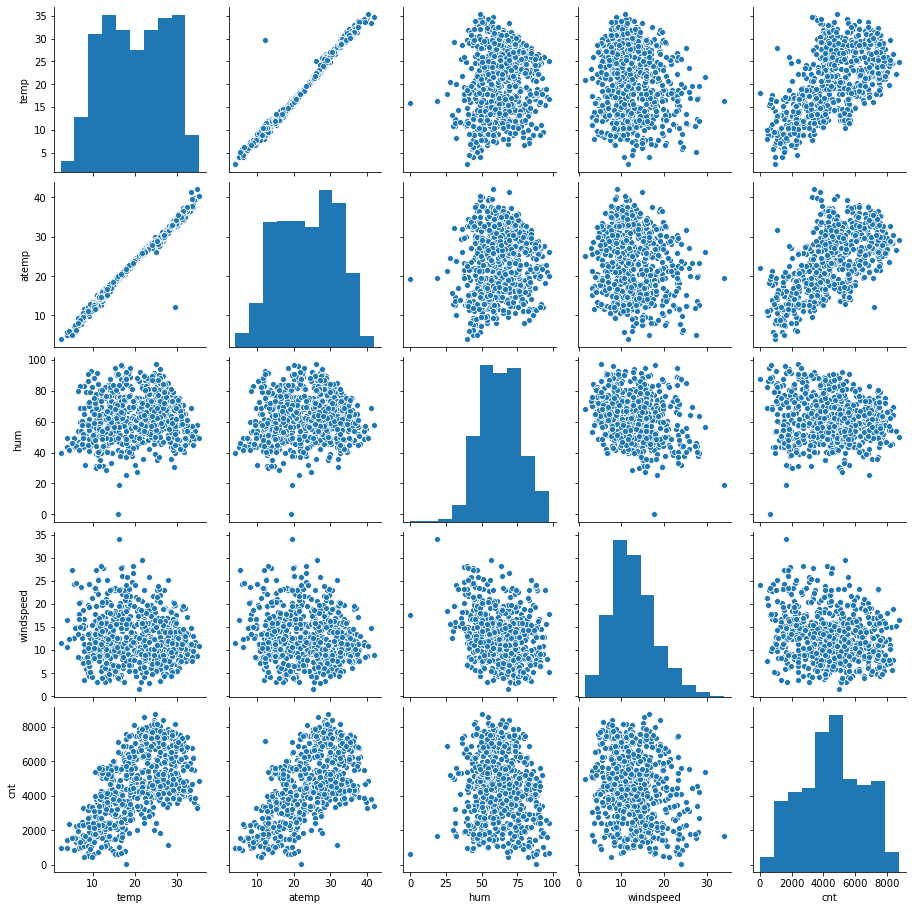

In [21]:
# Check various co-relation between numeric variables
sns.pairplot(bikes[numeric_vars])
plt.show()

# Pairplot analysis with numeric varibales

1. Count is more During working days as compared to holiday
2. Count is more During fall season  as compared to rest of the season
3. Count is more During clear weather as compared to rest of the weather
4. Count is more During Jun-Sep as compared to rest of months
5. Count is more During 2019 yr as compared to 2018 yr

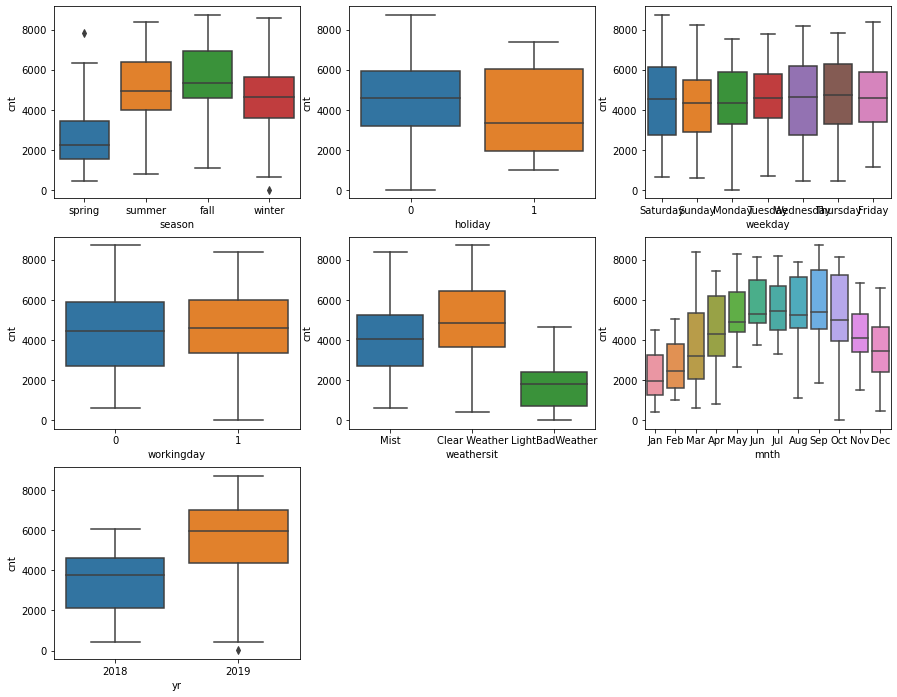

In [22]:

plt.figure(figsize=(15,12))

plt.subplot(3,3,1)
sns.boxplot(x='season',y='cnt',data=bikes)

plt.subplot(3,3,2)
sns.boxplot(x='holiday',y='cnt',data=bikes)

plt.subplot(3,3,3)
sns.boxplot(x='weekday',y='cnt',data=bikes)

plt.subplot(3,3,4)
sns.boxplot(x='workingday',y='cnt',data=bikes)

plt.subplot(3,3,5)
sns.boxplot(x='weathersit',y='cnt',data=bikes)

plt.subplot(3,3,6)
sns.boxplot(x='mnth',y='cnt',data=bikes)

plt.subplot(3,3,7)
sns.boxplot(x='yr',y='cnt',data=bikes)

In [23]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,12.522300,1600


In [24]:
# creating dummies for categorical variable : season
season = pd.get_dummies(bikes['season'], drop_first = True)
season.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [25]:
# merge season dummies with original dataframe
bikes =  pd.concat([bikes,season],axis = 1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


In [26]:
# creating dummies for categorical variable : mnth
mnth = pd.get_dummies(bikes['mnth'], drop_first = True)
mnth.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [27]:
# merge mnth dummies with original dataframe
bikes =  pd.concat([bikes,mnth],axis = 1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,...,0,0,1,0,0,0,0,0,0,0
1,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,...,0,0,1,0,0,0,0,0,0,0
2,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,...,0,0,1,0,0,0,0,0,0,0
3,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,...,0,0,1,0,0,0,0,0,0,0
4,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,...,0,0,1,0,0,0,0,0,0,0


In [28]:
# creating dummies for categorical variable : weathersit
weathersit = pd.get_dummies(bikes['weathersit'], drop_first = True)
weathersit.head()

,LightBadWeather,Mist
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [29]:
# merge easthersit dummies with original dataframe
bikes =  pd.concat([bikes,weathersit],axis = 1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,LightBadWeather,Mist
0,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,...,1,0,0,0,0,0,0,0,0,1
1,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,...,1,0,0,0,0,0,0,0,0,1
2,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,...,1,0,0,0,0,0,0,0,0,0
3,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,...,1,0,0,0,0,0,0,0,0,0
4,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,...,1,0,0,0,0,0,0,0,0,0


In [30]:
# creating dummies for categorical variable : yr
yr = pd.get_dummies(bikes['yr'], drop_first = True)
yr.head()

,2019
0,0
1,0
2,0
3,0
4,0


In [31]:
# merge yr dummies with original dataframe
bikes =  pd.concat([bikes,yr],axis = 1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Jul,Jun,Mar,May,Nov,Oct,Sep,LightBadWeather,Mist,2019
0,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,...,0,0,0,0,0,0,0,0,1,0
1,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,...,0,0,0,0,0,0,0,0,1,0
2,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,...,0,0,0,0,0,0,0,0,0,0
3,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,...,0,0,0,0,0,0,0,0,0,0
4,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# creating dummies for categorical variable : weekday
weekday = pd.get_dummies(bikes['weekday'], drop_first = True)
weekday.head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1


In [33]:
# merge weekday dummies with original dataframe
bikes =  pd.concat([bikes,weekday],axis = 1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Sep,LightBadWeather,Mist,2019,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,spring,2018,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,...,0,0,1,0,0,1,0,0,0,0
1,spring,2018,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,...,0,0,1,0,0,0,1,0,0,0
2,spring,2018,Jan,0,Monday,1,Clear Weather,8.050924,9.47025,43.7273,...,0,0,0,0,1,0,0,0,0,0
3,spring,2018,Jan,0,Tuesday,1,Clear Weather,8.200000,10.60610,59.0435,...,0,0,0,0,0,0,0,0,1,0
4,spring,2018,Jan,0,Wednesday,1,Clear Weather,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,0,0,1


In [34]:
# Drop original columns which are already conbverted as dummies
bikes = bikes.drop(['season','yr','mnth','weekday','weathersit'],axis = 1)
bikes.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,Sep,LightBadWeather,Mist,2019,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Train & Test split 70 / 30 ratio

In [35]:
bikes_train, bikes_test = train_test_split(bikes,train_size=0.7, random_state=100)

In [36]:
print(bikes_train.shape)
print(bikes_test.shape)

(510, 30)
(220, 30)


# Data before scaling

In [37]:
bikes_train.head()


,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,Sep,LightBadWeather,Mist,2019,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
576,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,0,...,0,0,0,1,0,0,0,0,1,0
426,0,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,0,...,0,0,1,1,0,1,0,0,0,0
728,0,0,10.489153,11.5850,48.3333,23.500518,1796,1,0,0,...,0,0,0,1,0,0,1,0,0,0
482,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,0,...,0,0,1,1,0,1,0,0,0,0
111,0,1,13.803347,16.0977,72.9583,14.707907,1683,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [38]:
# Perform scaling on training data using MinMaxScaler of numeric vars

In [39]:

# Instatiate asn object
scaler = MinMaxScaler()

# Scale only numeric variable
# create a list of numeric variables
num_vars = ['temp','atemp','hum','windspeed','cnt']
# 2. Fit_transform on data

bikes_train[num_vars] = scaler.fit_transform(bikes_train[num_vars])




# Data after Scaling

In [40]:
bikes_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,Sep,LightBadWeather,Mist,2019,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
576,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,1,0,0,0,0,1,0
426,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,1,0,1,0,0,0,0
728,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,1,0,0,1,0,0,0
482,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,1,0,1,0,0,0,0
111,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [41]:
bikes_train[num_vars].describe()

,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883,0.513499
std,0.225858,0.212410,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.542596,0.529718,0.653714,0.296763,0.518638
75%,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Train the model

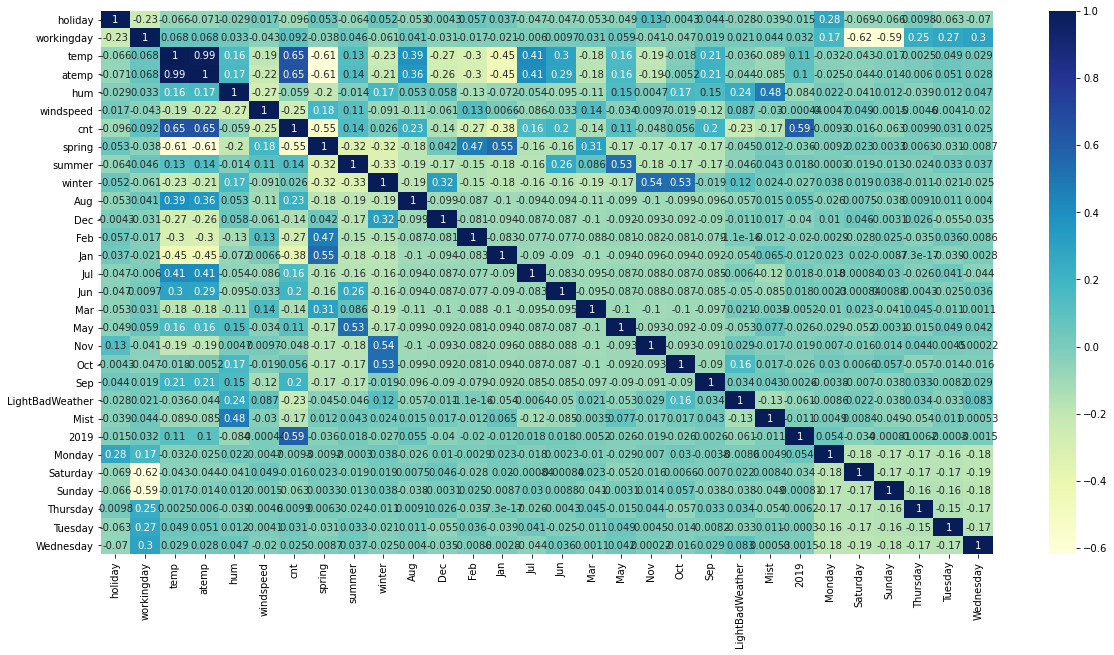

In [42]:
# heatmap to see corr
plt.figure(figsize = (20,10))
sns.heatmap(bikes_train.corr(),annot = True, cmap = 'YlGnBu')
plt.show()

In [43]:
# Start with area X_train, y_train

y_train = bikes_train.pop('cnt')
X_train = bikes_train


In [44]:
y_train.shape

(510,)

In [45]:
# Use RFE to perform Linear Regression & see 15 variable their rankings etc
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,15)
rfe = rfe.fit(X_train,y_train)

In [46]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Aug', False, 7),
 ('Dec', False, 3),
 ('Feb', False, 4),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 14),
 ('Mar', False, 15),
 ('May', False, 6),
 ('Nov', False, 2),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('LightBadWeather', True, 1),
 ('Mist', True, 1),
 ('2019', True, 1),
 ('Monday', False, 9),
 ('Saturday', True, 1),
 ('Sunday', False, 8),
 ('Thursday', False, 11),
 ('Tuesday', False, 10),
 ('Wednesday', False, 12)]

In [47]:
# rfe columns
col = X_train.columns[rfe.support_]

In [48]:
col

Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'summer',
       'winter', 'Jan', 'Jul', 'Sep', 'LightBadWeather', 'Mist', '2019',
       'Saturday'],
      dtype='object')

In [49]:
X_train.columns[~rfe.support_]

Index(['atemp', 'Aug', 'Dec', 'Feb', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Monday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

## Building Model with RFE

In [50]:
X_train_rfe = X_train[col]

In [51]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [52]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [53]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          4.22e-191
Time:                        22:12:18   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2519      0.036      6.969      0.000       0.181       0.323
holiday            -0.0582      0.027     -2.164      0.031      -0.111      -0.005
workingday          0.0433      0.012      3.762      0.000       0.021       0.066
temp                0.5096      0.034     14.837      0.000       0.442       0.577
hum                -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed          -0.1863      0.025     -7.310      0.000      -0.236      -0.136
spring             -0.0509      0.021     -2.464      0.014      -0.091      -0.010
summer              0.0508      0.015      3.423      0.001       0.022       0.080
winter              0.0933      0.017      5.403      0.000       0.059       0.127
Jan                -0.0345      0.017     -1.989      0.047      -0.069      -0.000
Jul                -0.0529      0.018     -2.931      0.004      -0.088      -0.017
Sep                 0.0814      0.016      4.945      0.000       0.049       0.114
LightBadWeather    -0.2475      0.026     -9.507      0.000      -0.299      -0.196
Mist               -0.0563      0.010     -5.439      0.000      -0.077      -0.036
2019                0.2305      0.008     28.795      0.000       0.215       0.246
Saturday            0.0536      0.014      3.694      0.000       0.025       0.082
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Iterate below step to elimiate all variable which are having p-value >0 once done then see VIF bvalues if VIF > 5 then drop that column as well

In [54]:
X_train_rfe = X_train_rfe.drop('Jan',axis = 1)

In [55]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [56]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [57]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          2.11e-191
Time:                        22:12:19   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2402      0.036      6.714      0.000       0.170       0.310
holiday            -0.0591      0.027     -2.192      0.029      -0.112      -0.006
workingday          0.0430      0.012      3.725      0.000       0.020       0.066
temp                0.5277      0.033     15.884      0.000       0.462       0.593
hum                -0.1611      0.037     -4.313      0.000      -0.234      -0.088
windspeed          -0.1809      0.025     -7.118      0.000      -0.231      -0.131
spring             -0.0555      0.021     -2.698      0.007      -0.096      -0.015
summer              0.0537      0.015      3.631      0.000       0.025       0.083
winter              0.0992      0.017      5.815      0.000       0.066       0.133
Jul                -0.0546      0.018     -3.019      0.003      -0.090      -0.019
Sep                 0.0820      0.017      4.966      0.000       0.050       0.114
LightBadWeather    -0.2450      0.026     -9.395      0.000      -0.296      -0.194
Mist               -0.0563      0.010     -5.425      0.000      -0.077      -0.036
2019                0.2298      0.008     28.647      0.000       0.214       0.246
Saturday            0.0530      0.015      3.648      0.000       0.024       0.082
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.630
Skew:                          -0.663   Prob(JB):                     9.73e-35
Kurtosis:                       5.369   Cond. No.                         21.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
X_train_rfe = X_train_rfe.drop('holiday',axis = 1)

In [59]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [60]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [61]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.8
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.54e-191
Time:                        22:12:20   Log-Likelihood:                 515.15
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     496   BIC:                            -943.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2307      0.036      6.472      0.000       0.161       0.301
workingday          0.0518      0.011      4.764      0.000       0.030       0.073
temp                0.5278      0.033     15.827      0.000       0.462       0.593
hum                -0.1594      0.037     -4.253      0.000      -0.233      -0.086
windspeed          -0.1815      0.026     -7.114      0.000      -0.232      -0.131
spring             -0.0566      0.021     -2.740      0.006      -0.097      -0.016
summer              0.0541      0.015      3.640      0.000       0.025       0.083
winter              0.0983      0.017      5.738      0.000       0.065       0.132
Jul                -0.0535      0.018     -2.946      0.003      -0.089      -0.018
Sep                 0.0799      0.017      4.831      0.000       0.047       0.112
LightBadWeather    -0.2442      0.026     -9.330      0.000      -0.296      -0.193
Mist               -0.0561      0.010     -5.379      0.000      -0.077      -0.036
2019                0.2300      0.008     28.568      0.000       0.214       0.246
Saturday            0.0619      0.014      4.420      0.000       0.034       0.089
==============================================================================
Omnibus:                       71.537   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.647
Skew:                          -0.709   Prob(JB):                     1.32e-40
Kurtosis:                       5.576   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
X_train_rfe = X_train_rfe.drop('const',axis = 1)

In [63]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i)  for i in range(X.shape[1]) ]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

,Features,VIF
2,hum,28.38
1,temp,16.88
0,workingday,4.72
3,windspeed,4.70
4,spring,4.18
6,winter,3.39
5,summer,2.84
10,Mist,2.28
11,2019,2.08
12,Saturday,1.84


In [64]:
X_train_rfe = X_train_rfe.drop('spring',axis = 1)

In [65]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [66]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [67]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     222.7
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          4.14e-191
Time:                        22:12:21   Log-Likelihood:                 511.32
No. Observations:                 510   AIC:                            -996.6
Df Residuals:                     497   BIC:                            -941.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1712      0.028      6.014      0.000       0.115       0.227
workingday          0.0524      0.011      4.791      0.000       0.031       0.074
temp                0.5960      0.022     26.667      0.000       0.552       0.640
hum                -0.1709      0.037     -4.558      0.000      -0.245      -0.097
windspeed          -0.1888      0.026     -7.393      0.000      -0.239      -0.139
summer              0.0827      0.011      7.770      0.000       0.062       0.104
winter              0.1355      0.010     12.930      0.000       0.115       0.156
Jul                -0.0439      0.018     -2.450      0.015      -0.079      -0.009
Sep                 0.0928      0.016      5.816      0.000       0.061       0.124
LightBadWeather    -0.2391      0.026     -9.100      0.000      -0.291      -0.188
Mist               -0.0536      0.010     -5.129      0.000      -0.074      -0.033
2019                0.2286      0.008     28.267      0.000       0.213       0.244
Saturday            0.0625      0.014      4.429      0.000       0.035       0.090
==============================================================================
Omnibus:                       65.304   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.523
Skew:                          -0.689   Prob(JB):                     5.61e-33
Kurtosis:                       5.257   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
X_train_rfe = X_train_rfe.drop('const',axis = 1)

In [69]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i)  for i in range(X.shape[1]) ]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

,Features,VIF
2,hum,16.21
1,temp,10.36
0,workingday,4.54
3,windspeed,3.73
9,Mist,2.10
10,2019,2.03
11,Saturday,1.79
4,summer,1.76
5,winter,1.70
6,Jul,1.55


In [70]:
X_train_rfe = X_train_rfe.drop('Jul',axis = 1)

In [71]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [72]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [73]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     240.0
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          5.10e-191
Time:                        22:12:23   Log-Likelihood:                 508.25
No. Observations:                 510   AIC:                            -992.5
Df Residuals:                     498   BIC:                            -941.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1705      0.029      5.960      0.000       0.114       0.227
workingday          0.0533      0.011      4.849      0.000       0.032       0.075
temp                0.5710      0.020     28.558      0.000       0.532       0.610
hum                -0.1629      0.038     -4.340      0.000      -0.237      -0.089
windspeed          -0.1864      0.026     -7.268      0.000      -0.237      -0.136
summer              0.0910      0.010      8.984      0.000       0.071       0.111
winter              0.1396      0.010     13.430      0.000       0.119       0.160
Sep                 0.1027      0.016      6.619      0.000       0.072       0.133
LightBadWeather    -0.2426      0.026     -9.197      0.000      -0.294      -0.191
Mist               -0.0538      0.011     -5.124      0.000      -0.074      -0.033
2019                0.2294      0.008     28.258      0.000       0.213       0.245
Saturday            0.0628      0.014      4.433      0.000       0.035       0.091
==============================================================================
Omnibus:                       72.400   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.721
Skew:                          -0.755   Prob(JB):                     1.03e-36
Kurtosis:                       5.349   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
X_train_rfe = X_train_rfe.drop('const',axis = 1)

In [75]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i)  for i in range(X.shape[1]) ]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

,Features,VIF
2,hum,15.96
1,temp,8.12
0,workingday,4.53
3,windspeed,3.73
8,Mist,2.10
9,2019,2.02
10,Saturday,1.79
5,winter,1.66
4,summer,1.58
6,Sep,1.20


In [76]:
X_train_rfe = X_train_rfe.drop('hum',axis = 1)

In [77]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [78]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [79]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          3.13e-188
Time:                        22:12:24   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0750      0.019      4.031      0.000       0.038       0.112
workingday          0.0561      0.011      5.024      0.000       0.034       0.078
temp                0.5499      0.020     27.861      0.000       0.511       0.589
windspeed          -0.1552      0.025     -6.195      0.000      -0.204      -0.106
summer              0.0886      0.010      8.608      0.000       0.068       0.109
winter              0.1307      0.010     12.600      0.000       0.110       0.151
Sep                 0.0974      0.016      6.184      0.000       0.066       0.128
LightBadWeather    -0.2871      0.025    -11.611      0.000      -0.336      -0.239
Mist               -0.0800      0.009     -9.143      0.000      -0.097      -0.063
2019                0.2331      0.008     28.370      0.000       0.217       0.249
Saturday            0.0675      0.014      4.693      0.000       0.039       0.096
==============================================================================
Omnibus:                       68.639   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.839
Skew:                          -0.731   Prob(JB):                     1.07e-33
Kurtosis:                       5.238   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
X_train_new = X_train_rfe.drop('const',axis = 1)

### See if VIF is less than < 5 then no more drop attribute

In [81]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i)  for i in range(X.shape[1]) ]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

,Features,VIF
1,temp,4.76
0,workingday,4.04
2,windspeed,3.44
8,2019,2.02
9,Saturday,1.69
3,summer,1.57
7,Mist,1.53
4,winter,1.40
5,Sep,1.20
6,LightBadWeather,1.08


# Assumptions Validated 
No Multicollinearity - VIF < 5

## Residual analysis

In [82]:
y_train_cnt = lm.predict(X_train_rfe)

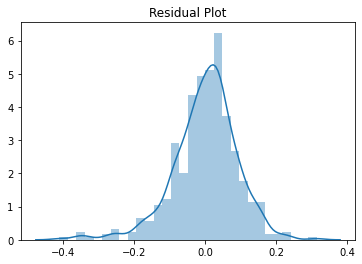

In [83]:
res = y_train - y_train_cnt
sns.distplot(res)
plt.title("Residual Plot")
plt.show()

# Assumptions Validated 
Residual are normally distributed

## Scale the test data 

In [84]:
bikes_test[numeric_vars] = scaler.transform(bikes_test[numeric_vars])

In [85]:
y_test = bikes_test.pop('cnt')
X_test = bikes_test

In [86]:
X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)

In [87]:
y_test_pred = lm.predict(X_test_new)

## Model Evaluation

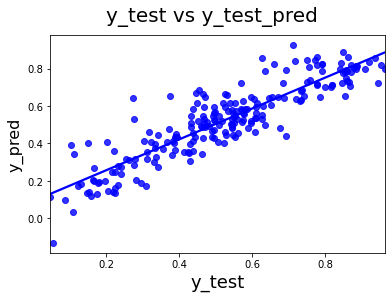

In [88]:
fig = plt.figure()
#plt.scatter(y_test,y_test_pred)
sns.regplot(x=y_test,y=y_test_pred,ci=None,color ='blue');
fig.suptitle('y_test vs y_test_pred', fontsize=20)
plt.xlabel('y_test',fontsize=18)
plt.ylabel('y_pred',fontsize=16)
plt.show()

# Assumptions Validated 
Linear Relationship with Indepdenent & Dependent variable

# Assumptions Validated 
Homoscedasticity Residual have constant variance n linear model

In [89]:
r2_score(y_test, y_test_pred)

0.7961390438459764

## R2_score is within 5% of R2 Square